# Setup

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.tsa.seasonal import STL

In [2]:
plt.rcParams['axes.prop_cycle'] = cycler(color=['k'])

## Import example dataset

This is a simulated dataset that mimics aggregated daily active users for a product such as an application.<br>
timestamp: primary key that depects 1 day per row.<br>
daily_active_users: sum of daily active users group by timestamp

In [3]:
df = pd.read_csv('product_usage_data.csv')
df.head()

,timestamp,daily_active_users
0,1/1/2024,1107
1,1/2/2024,1113
2,1/3/2024,1143
3,1/4/2024,1140
4,1/5/2024,1136


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df.head()

,timestamp,daily_active_users
0,2024-01-01,1107
1,2024-01-02,1113
2,2024-01-03,1143
3,2024-01-04,1140
4,2024-01-05,1136


In [6]:
dau = pd.Series(data=df['daily_active_users'].values, index=df['timestamp'])

<Axes: xlabel='timestamp'>

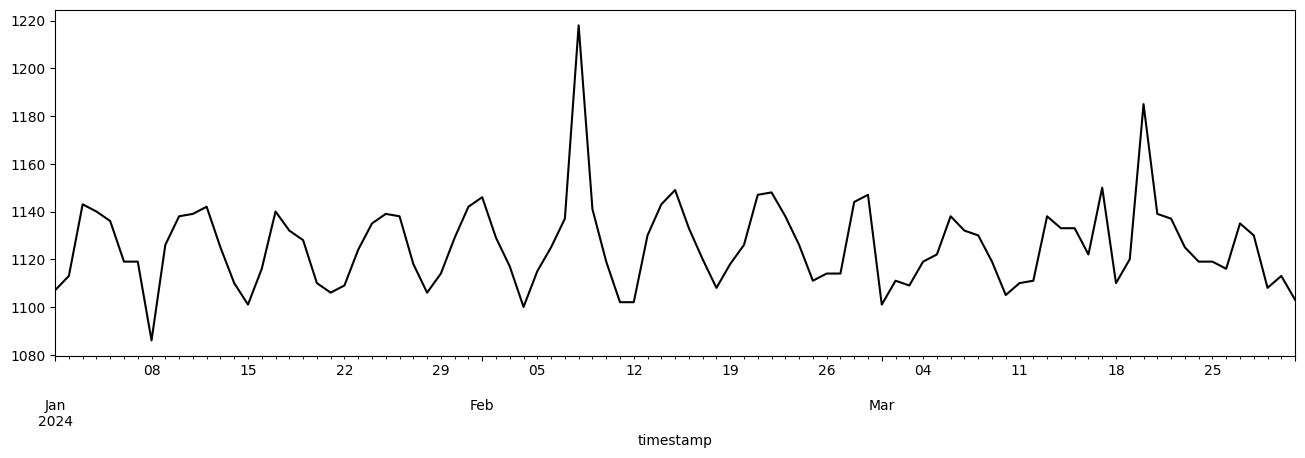

In [7]:
dau.plot(figsize=(16,4.5))

In [8]:
dau.describe()

count      91.000000
mean     1125.703297
std        18.362700
min      1086.000000
25%      1113.000000
50%      1125.000000
75%      1138.000000
max      1218.000000
dtype: float64

## Run Seasonal Trend Decomposition (STL)

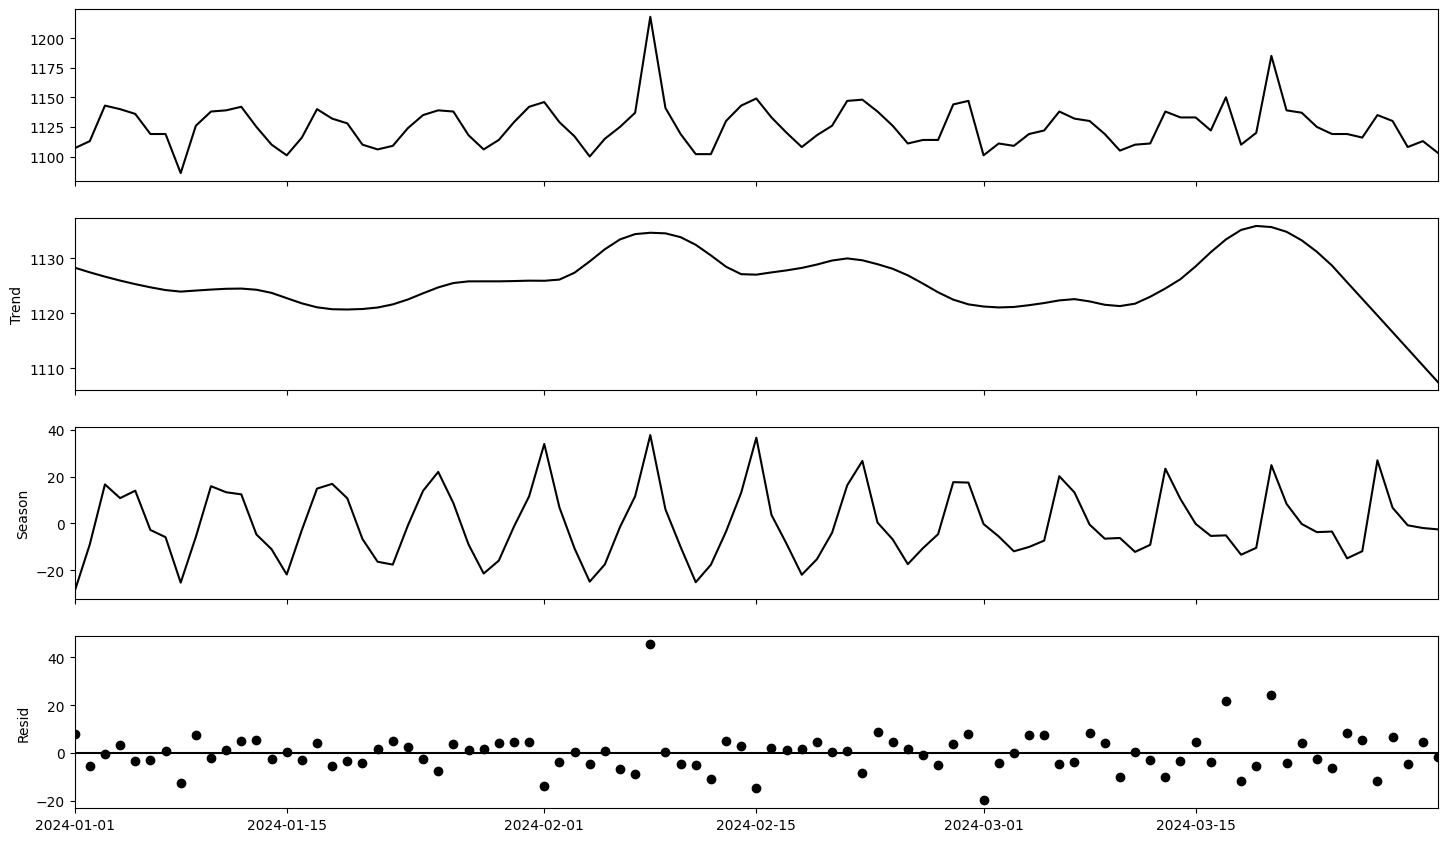

In [9]:
stl = STL(dau, period=7)  # weekly seasonality
res = stl.fit()

# Plot residuals
fig = res.plot()
fig.set_size_inches((16, 9))

<Axes: title={'center': 'Residuals'}, xlabel='timestamp'>

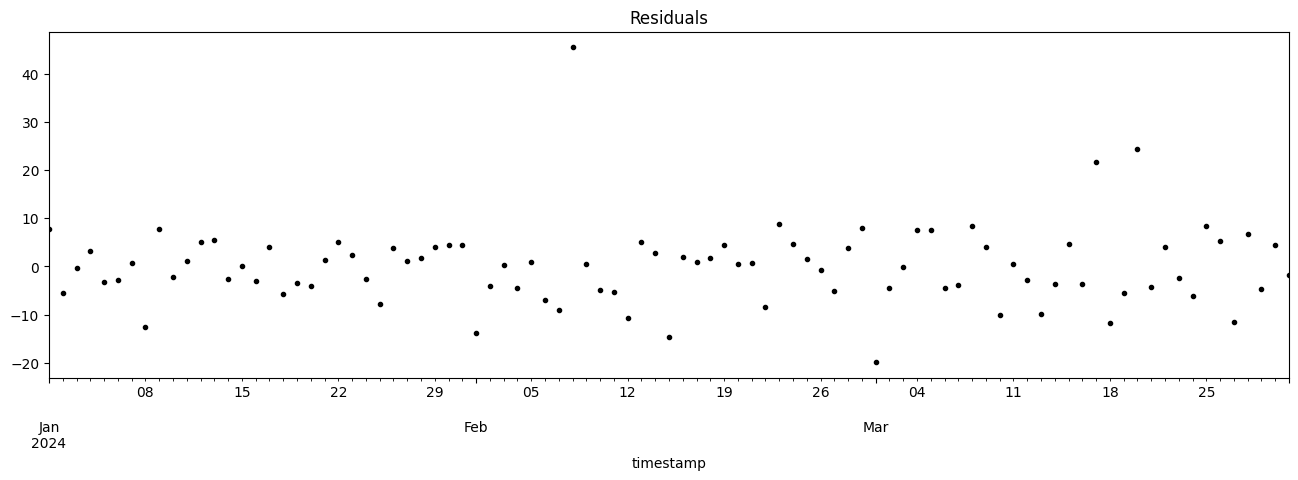

In [10]:
res.resid.plot(marker='.', linestyle='none', figsize=(16,4.5), title='Residuals')

## Identify anomalies based on trend and residuals

I am using 3 different confidence intervals (90%, 95%, 99.7%) to determine severity of anomalies. These correspond to 1, 2, and 3 standard deviations respectively.

In [11]:
trend_iv_l_minor = pd.Series(data=res.trend.values-np.mean(res.trend)-np.std(res.resid), index=res.trend.index)
trend_iv_u_minor = pd.Series(data=res.trend.values-np.mean(res.trend)+np.std(res.resid), index=res.trend.index)\

trend_iv_l_major = pd.Series(data=res.trend.values-np.mean(res.trend)-2*np.std(res.resid), index=res.trend.index)
trend_iv_u_major = pd.Series(data=res.trend.values-np.mean(res.trend)+2*np.std(res.resid), index=res.trend.index)

trend_iv_l_severe = pd.Series(data=res.trend.values-np.mean(res.trend)-3*np.std(res.resid), index=res.trend.index)
trend_iv_u_severe = pd.Series(data=res.trend.values-np.mean(res.trend)+3*np.std(res.resid), index=res.trend.index)

In [12]:
minor_anom = np.where((res.resid < trend_iv_l_minor) | (res.resid > trend_iv_u_minor), res.resid, np.nan)
major_anom = np.where((res.resid < trend_iv_l_major) | (res.resid > trend_iv_u_major), res.resid, np.nan)
severe_anom = np.where((res.resid < trend_iv_l_severe) | (res.resid > trend_iv_u_severe), res.resid, np.nan)

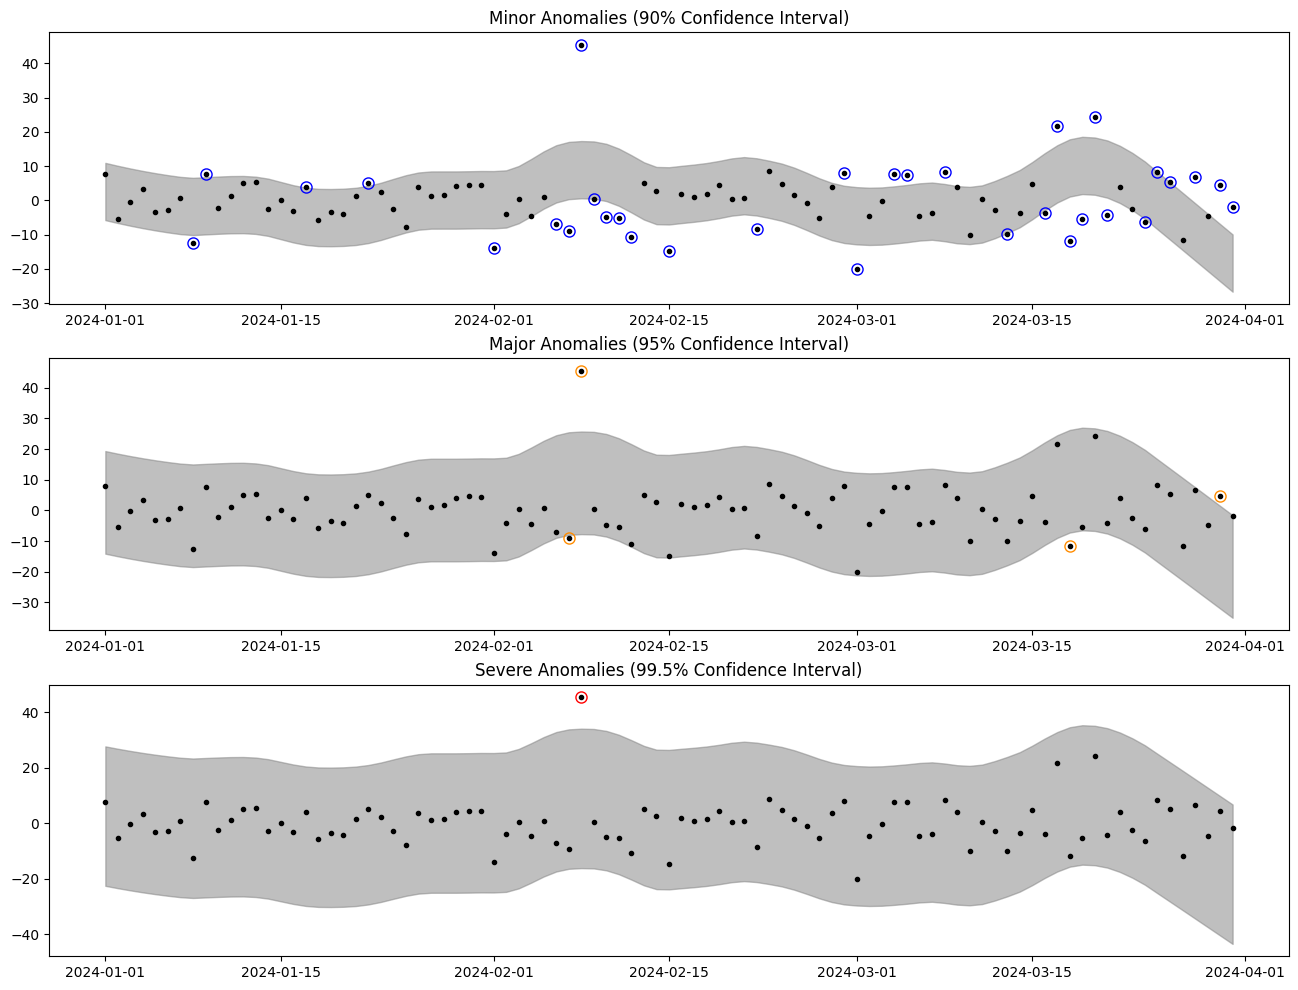

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(16, 12))
ax1.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax1.plot(pd.Series(minor_anom, res.resid.index), marker='o', linestyle='none', label='Residuals', color='blue', fillstyle='none', markersize=8)
ax1.set_title('Minor Anomalies (90% Confidence Interval)')
ax1.fill_between(res.resid.index, trend_iv_l_minor, trend_iv_u_minor, color='grey', alpha=0.5, label='confidence interval')

ax2.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax2.plot(pd.Series(major_anom, res.resid.index), marker='o', linestyle='none', label='Residuals',  color='darkorange', fillstyle='none', markersize=8)
ax2.set_title('Major Anomalies (95% Confidence Interval)')
ax2.fill_between(res.resid.index, trend_iv_l_major, trend_iv_u_major, color='grey', alpha=0.5, label='confidence interval')

ax3.plot(res.resid, marker='.', linestyle='none', label='Residuals')
ax3.plot(pd.Series(severe_anom, res.resid.index), marker='o', linestyle='none', label='Residuals',  color='red', fillstyle='none', markersize=8)
ax3.set_title('Severe Anomalies (99.5% Confidence Interval)')
ax3.fill_between(res.resid.index, trend_iv_l_severe, trend_iv_u_severe, color='grey', alpha=0.5, label='confidence interval')

In [14]:
ax1.plot(minor_anom, marker='.', linestyle='none', label='Anomalies')

## Rerun Seasonal Trend Decomposition with anomaly detection

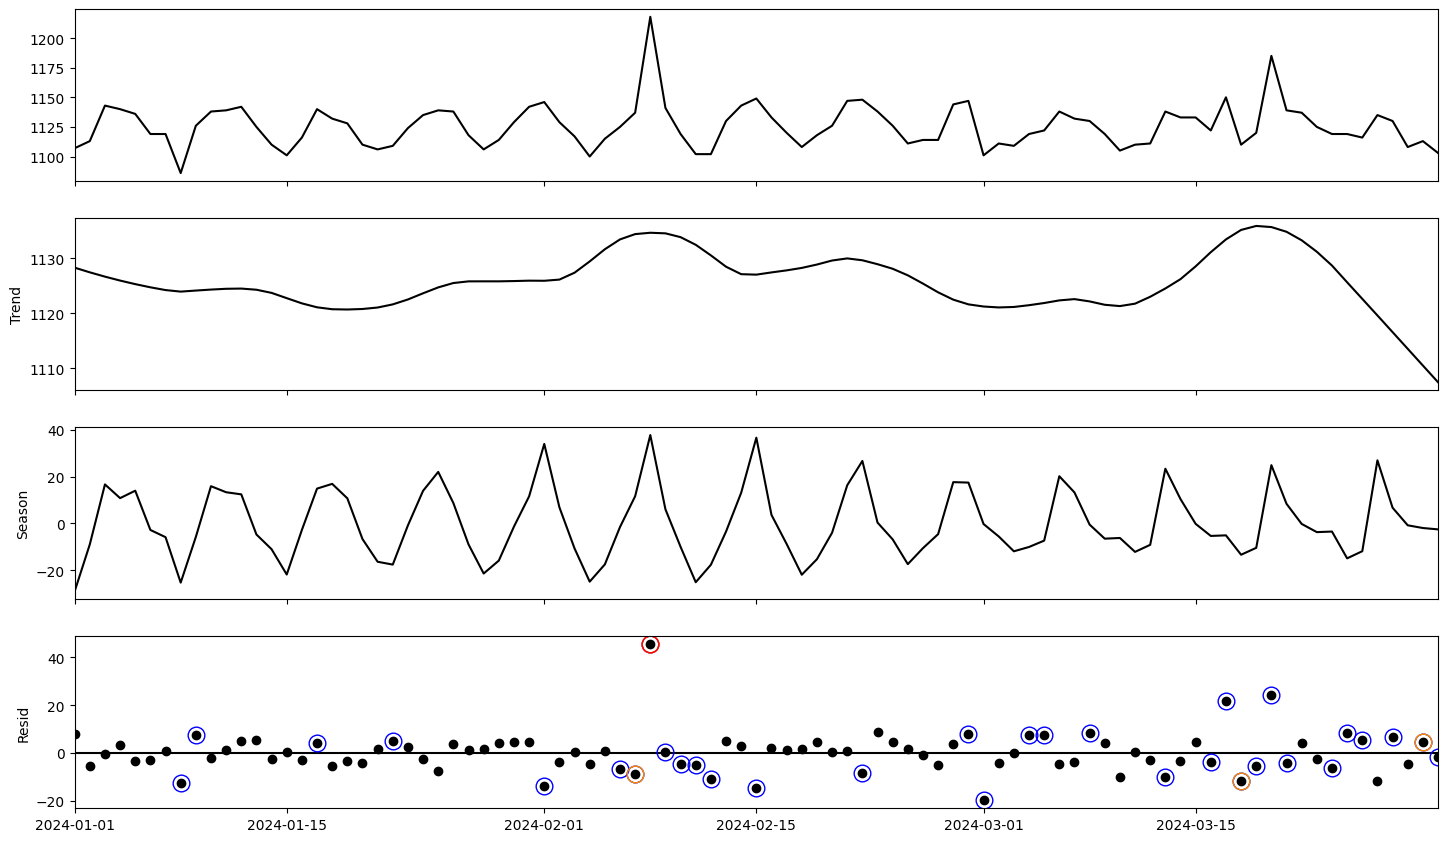

In [15]:
stl = STL(dau)
res = stl.fit()

# Plot residuals
fig = res.plot()
fig.set_size_inches((16, 9))

# Get the residuals axes (it's the last one in the STL plot)
data_ax = fig.get_axes()[0]
resid_ax = fig.get_axes()[-1]

# Highlight anomalies in the residuals plot
resid_ax.plot(res.resid.index, minor_anom, 'o', color='b', fillstyle='none', markersize=12)
resid_ax.plot(res.resid.index, major_anom, 'o', color='darkorange', fillstyle='none', markersize=12)
resid_ax.plot(res.resid.index, severe_anom, 'o', color='r', fillstyle='none', markersize=12)

In [16]:
import pmdarima as pm
from pmdarima import model_selection

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=622.833, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=626.812, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=622.886, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=602.004, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1218.031, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=613.331, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=604.007, Time=0.19 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=597.498, Time=0.12 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=599.379, Time=0.11 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=599.968, Time=0.31 sec
 ARIMA(0,0,2)(0,0,2)[7] intercept   : AIC=599.283, Time=0.11 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=600.529, Time=0.14 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC=601.449, Time=0.39 sec
 ARIMA(0,0,1)(0,0,2)[7]             : AIC=inf, Tim

Text(0.5, 1.0, 'Added new observed values with new forecasts')

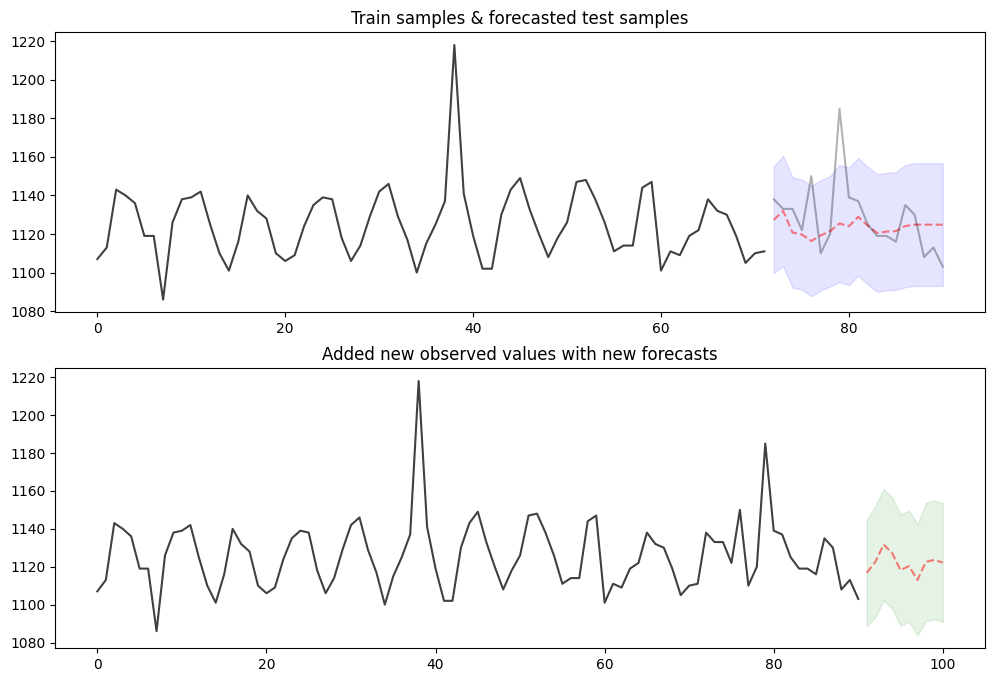

In [31]:
train, test = model_selection.train_test_split(dau.values, train_size=0.8)

arima = pm.auto_arima(train, max_iter=5, m=7, suppress_warnings=True,
                      stepwise=True, error_action='ignore', trace=True)

preds, conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].plot(x_axis[train.shape[0]:], preds, alpha=0.5, linestyle='--', color='r')
axes[0].plot(x_axis[train.shape[0]:], test, alpha=0.3)
axes[0].fill_between(x_axis[-preds.shape[0]:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
new_preds, new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(dau.shape[0] + 10)

axes[1].plot(new_x_axis[:dau.shape[0]], dau, alpha=0.75)
axes[1].plot(new_x_axis[dau.shape[0]:], new_preds, alpha=0.5, linestyle='--', color='r')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g') 
axes[1].set_title("Added new observed values with new forecasts")

In [18]:
trend = res.trend
seasonal = res.seasonal
resid = res.resid

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-17.419, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=398.608, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1218.088, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=-20.572, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=0.084, Time=0.15 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=-18.571, Time=0.53 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,0,2)(0,0,1)[7] intercept   : AIC=-16.923, Time=0.26 sec
 ARIMA(2,0,3)(0,0,1)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,3)(0,

Text(0.5, 1.0, 'Added new observed values with new forecasts')

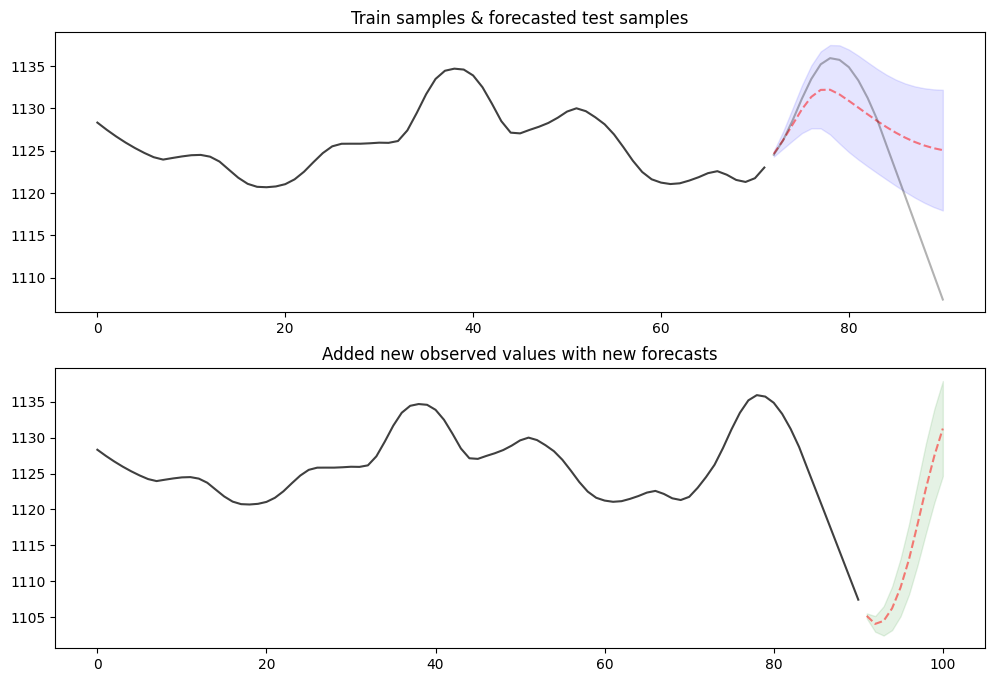

In [32]:
train, test = model_selection.train_test_split(trend.values, train_size=0.8)

arima = pm.auto_arima(train, max_iter=5, m=7, suppress_warnings=True,
                      stepwise=True, error_action='ignore', trace=True)

trend_preds, trend_conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + trend_preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].plot(x_axis[train.shape[0]:], trend_preds, alpha=0.5, linestyle='--', color='r')
axes[0].plot(x_axis[train.shape[0]:], test, alpha=0.3)
axes[0].fill_between(x_axis[-trend_preds.shape[0]:], trend_conf_int[:, 0], trend_conf_int[:, 1],
                     alpha=0.1, color='b')

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
trend_new_preds, trend_new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(trend.shape[0] + 10)

axes[1].plot(new_x_axis[:trend.shape[0]], trend, alpha=0.75)
axes[1].plot(new_x_axis[trend.shape[0]:], trend_new_preds, alpha=0.5, linestyle='--', color='r')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     trend_new_conf_int[:, 0],
                     trend_new_conf_int[:, 1],
                     alpha=0.1, color='g') 
axes[1].set_title("Added new observed values with new forecasts")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=265.423, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=351.482, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=310.439, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=319.067, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=349.503, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,2)(2,1,1)[7] intercept   : AIC=261.058, Time=0.79 sec
 ARIMA(2,0,2)(2,1,0)[7] intercept   : AIC=263.735, Time=0.73 sec
 ARIMA(2,0,2)(2,1,2)[7] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,0,2)(1,1,2)[7] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,0,2)(2,1,1)[7] intercept   : AIC=278.923, Time=0.55 sec
 ARIMA(2,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(3,0,2)(2,1,1)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,0,3)(2,1,1)[7] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0

Text(0.5, 1.0, 'Added new observed values with new forecasts')

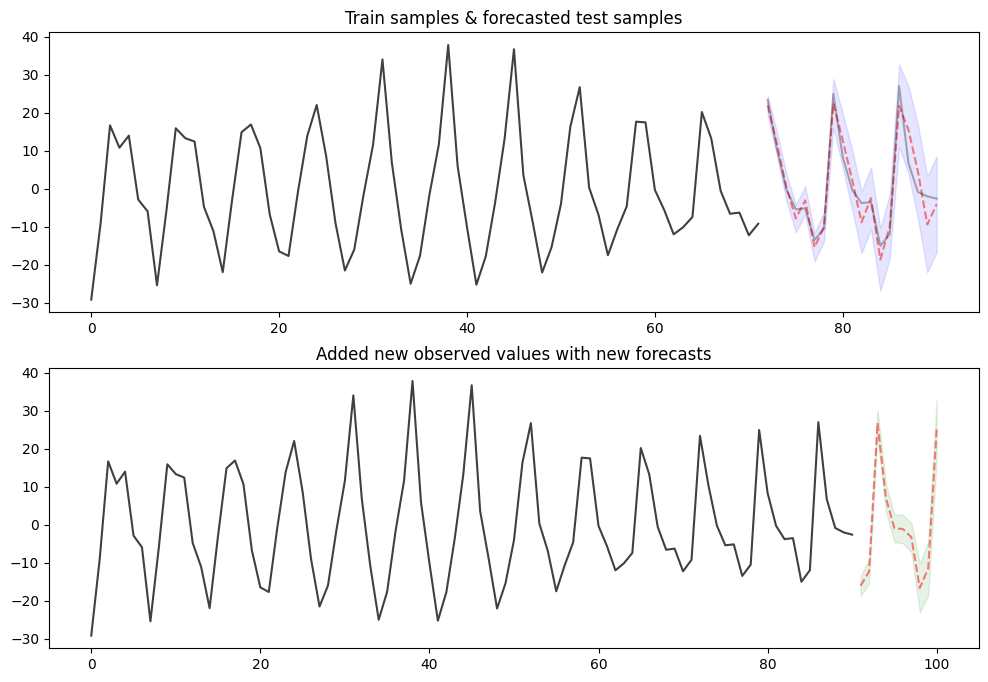

In [33]:
train, test = model_selection.train_test_split(seasonal.values, train_size=0.8)

arima = pm.auto_arima(train, max_iter=5, m=7, suppress_warnings=True,
                      stepwise=True, error_action='ignore', trace=True)

seasonal_preds, seasonal_conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + seasonal_preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].plot(x_axis[train.shape[0]:], seasonal_preds, alpha=0.5, linestyle='--', color='r')
axes[0].plot(x_axis[train.shape[0]:], test, alpha=0.3)
axes[0].fill_between(x_axis[-seasonal_preds.shape[0]:], seasonal_conf_int[:, 0], seasonal_conf_int[:, 1],
                     alpha=0.1, color='b')

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
seasonal_new_preds, seasonal_new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(seasonal.shape[0] + 10)

axes[1].plot(new_x_axis[:seasonal.shape[0]], seasonal, alpha=0.75)
axes[1].plot(new_x_axis[seasonal.shape[0]:], seasonal_new_preds, alpha=0.5, linestyle='--', color='r')
axes[1].fill_between(new_x_axis[-seasonal_new_preds.shape[0]:],
                     seasonal_new_conf_int[:, 0],
                     seasonal_new_conf_int[:, 1],
                     alpha=0.1, color='g') 
axes[1].set_title("Added new observed values with new forecasts")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=507.409, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=494.808, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=475.007, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=505.419, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=507.189, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=476.986, Time=0.09 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=493.960, Time=0.05 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=474.772, Time=0.04 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=476.768, Time=0.06 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=476.766, Time=0.09 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=493.948, Time=0.04 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.14 se

Text(0.5, 1.0, 'Added new observed values with new forecasts')

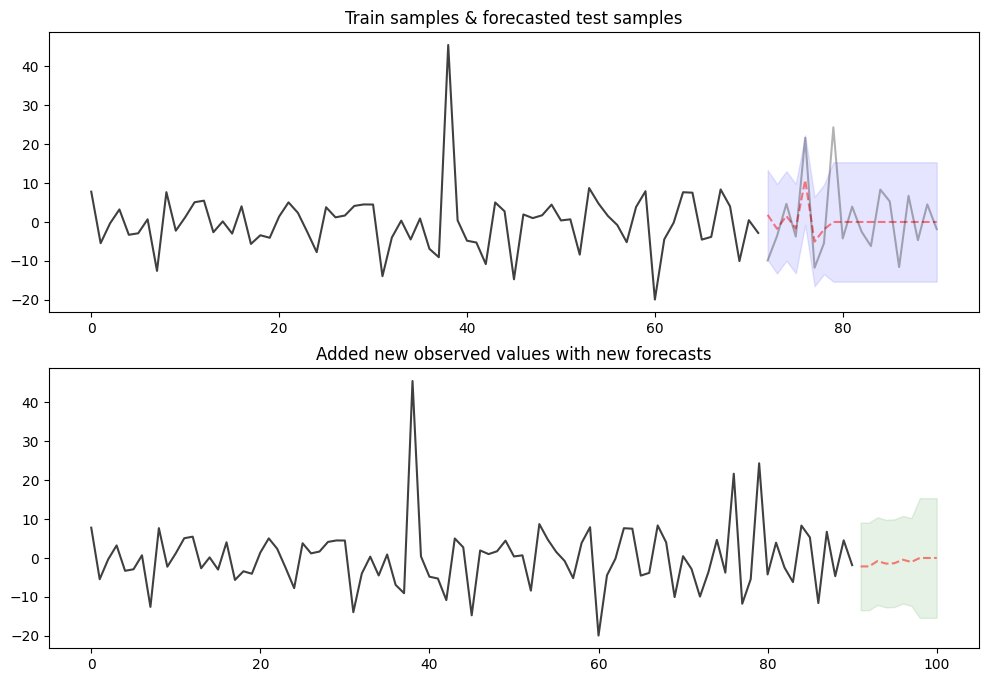

In [34]:
train, test = model_selection.train_test_split(resid.values, train_size=0.8)

arima = pm.auto_arima(train, max_iter=5, m=7, suppress_warnings=True,
                      stepwise=True, error_action='ignore', trace=True)

resid_preds, resid_conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + resid_preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].plot(x_axis[train.shape[0]:], resid_preds, alpha=0.5, linestyle='--', color='r')
axes[0].plot(x_axis[train.shape[0]:], test, alpha=0.3)
axes[0].fill_between(x_axis[-resid_preds.shape[0]:], resid_conf_int[:, 0], resid_conf_int[:, 1],
                     alpha=0.1, color='b')

axes[0].set_title("Train samples & forecasted test samples")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
resid_new_preds, resid_new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(resid.shape[0] + 10)

axes[1].plot(new_x_axis[:resid.shape[0]], resid, alpha=0.75)
axes[1].plot(new_x_axis[resid.shape[0]:], resid_new_preds, alpha=0.5, linestyle='--', color='r')
axes[1].fill_between(new_x_axis[-resid_new_preds.shape[0]:],
                     resid_new_conf_int[:, 0],
                     resid_new_conf_int[:, 1],
                     alpha=0.1, color='g') 
axes[1].set_title("Added new observed values with new forecasts")

In [22]:
stl_preds = trend_preds + seasonal_preds + resid_preds
stl_new_preds = trend_new_preds + seasonal_new_preds + resid_new_preds

stl_conf_int = trend_conf_int + seasonal_conf_int + resid_conf_int
stl_new_conf_int = trend_new_conf_int + seasonal_new_conf_int + resid_new_conf_int


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=622.833, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=626.812, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=622.886, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=602.004, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1218.031, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=613.331, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=604.007, Time=0.19 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=597.498, Time=0.11 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=599.379, Time=0.10 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=599.968, Time=0.29 sec
 ARIMA(0,0,2)(0,0,2)[7] intercept   : AIC=599.283, Time=0.11 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=600.529, Time=0.13 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC=601.449, Time=0.39 sec
 ARIMA(0,0,1)(0,0,2)[7]             : AIC=inf, Tim

Text(0.5, 1.0, 'Added new observed values with using new STL forecast')

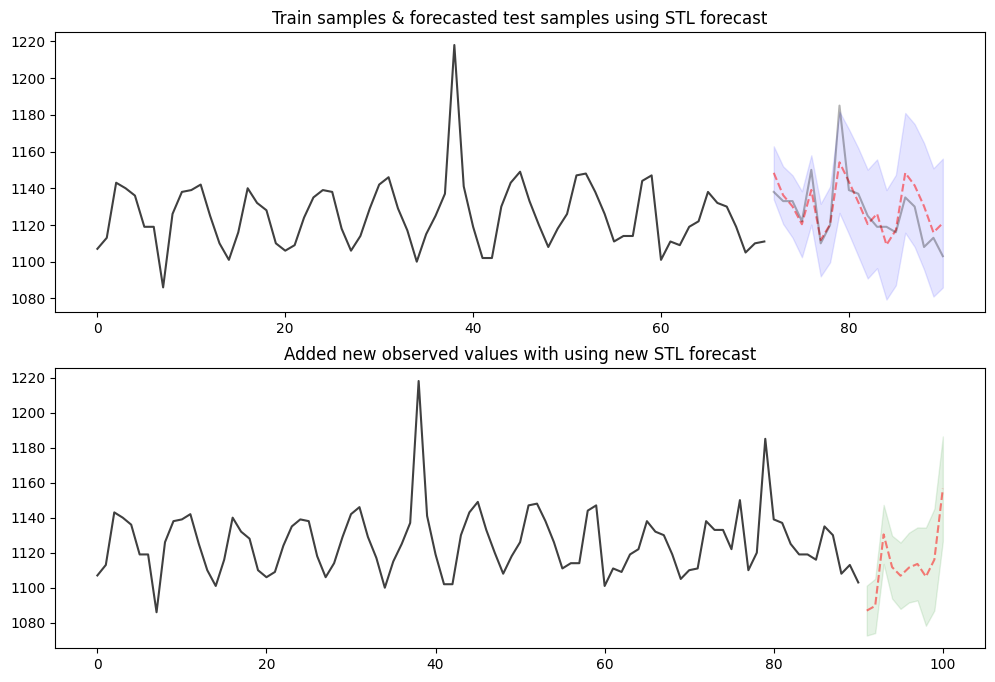

In [35]:
train, test = model_selection.train_test_split(dau.values, train_size=0.8)

arima = pm.auto_arima(train, max_iter=5, m=7, suppress_warnings=True,
                      stepwise=True, error_action='ignore', trace=True)

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
x_axis = np.arange(train.shape[0] + stl_preds.shape[0])
axes[0].plot(x_axis[:train.shape[0]], train, alpha=0.75)
axes[0].plot(x_axis[train.shape[0]:], stl_preds, alpha=0.5, linestyle='--', color='r')
axes[0].plot(x_axis[train.shape[0]:], test, alpha=0.3)
axes[0].fill_between(x_axis[-stl_preds.shape[0]:], stl_conf_int[:, 0], stl_conf_int[:, 1],
                     alpha=0.1, color='b')

axes[0].set_title("Train samples & forecasted test samples using STL forecast")

# Now add the actual samples to the model and create NEW forecasts
arima.update(test)
new_x_axis = np.arange(dau.shape[0] + 10)

axes[1].plot(new_x_axis[:dau.shape[0]], dau, alpha=0.75)
axes[1].plot(new_x_axis[dau.shape[0]:], stl_new_preds, alpha=0.5, linestyle='--', color='r')
axes[1].fill_between(new_x_axis[-stl_new_preds.shape[0]:],
                     stl_new_conf_int[:, 0],
                     stl_new_conf_int[:, 1],
                     alpha=0.1, color='g') 
axes[1].set_title("Added new observed values with using new STL forecast")